In [16]:

"""
Implementation of Linear Spectral Unmixing Analysis (LSMA) for fractional roof material type

1. Load the image data (PlanetScope SuperDove 8-band w/ spectral indices)
3. Generate the PCA or MNF transformation from the imagery
4. Mask out vegetated pixels and water using NDVI
5. Perform endmember selection to for the mixture analysis
6. Run the LSMA, getting fractional cover image
7. Perform zonal statistics on OSM-ZTRAX footprint data
8. Eliminate footprints with < 90% of the appropriate roof material type

"""

%matplotlib inline

# # Install required packages 
# !pip install pysptools
# !pip install multiprocess
# !pip install cvxopt

import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import pysptools.util as sp_utils
import pysptools.noise as noise
import pysptools.abundance_maps as amap
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocess as mp
import cvxopt
import random
from osgeo import gdal
from osgeo import osr
from functools import partial
from functools import reduce

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Completed ...")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/code
Completed ...


In [15]:

"""
Supporting functions for the OPP rooftop materials mapping project

List of functions:

'array_to_tif': convert a numpy array to a GeoTIFF with spatial dimensions of a reference image
'pixel_to_xy': convert pixel to lat/long coordinates
'mnf_transform': generate N components of a Minimum Noise Fraction (MNF) transformation on an image array
'ravel_and_filter': converts a numpy array (m,n,p) to ((m*n), p)
'lsma': simple Linear Spectral Mixture Analysis (LSMA)
'mesma': extention of LSMA to handle multiple endmembers
'partition': split an array into chunks for multiprocessing work

"""


#############
# Functions #
#############


def array_to_tif(arr, ref, out_path, clip=False, shp=None):
    """
    Generate a xarray DataArray with spatial information
    Match dimensions to a reference image
    """
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=1,
                          dtype='float32', driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr


def pixel_to_xy(pixel_pairs, gt=None, wkt=None, path=None, dd=False):
    """
    Modified from code by Zachary Bears (zacharybears.com/using-python-to-
    translate-latlon-locations-to-pixels-on-a-geotiff/).
    This method translates given pixel locations into longitude-latitude
    locations on a given GeoTIFF. Arguments:
        pixel_pairs The pixel pairings to be translated in the form
                    [[x1, y1],[x2, y2]]
        gt          [Optional] A GDAL GeoTransform tuple
        wkt         [Optional] Projection information as Well-Known Text
        path        The file location of the GeoTIFF
        dd          True to use decimal degrees for longitude-latitude (False
                    is the default)

    NOTE: This method does not take into account pixel size and assumes a
            high enough image resolution for pixel size to be insignificant.
    """

    pixel_pairs = map(list, pixel_pairs)
    srs = osr.SpatialReference()  # Create a spatial ref. for dataset
    srs.ImportFromWkt(wkt)

    # Go through all the point pairs and translate them to pixel pairings
    xy_pairs = []
    for point in pixel_pairs:
        # Translate the pixel pairs into untranslated points
        lon = point[0] * gt[1] + gt[0]
        lat = point[1] * gt[5] + gt[3]
        xy_pairs.append((lon, lat)) # Add the point to our return array

    return xy_pairs


def mnf_transform(data_arr,n_components=5,nodata=-9999):
    """
        Applies the MNF rotation to a raster array; returns in HSI form
        (m x n x p). Arguments:
            rast    A NumPy raster array
            nodata  The NoData value
    """
    arr = data_arr.copy().transpose()
    arr[arr == nodata] = 0  # Remap any lingering NoData values
    # Apply the Minimum Noise Fraction (MNF) rotation
    mnf = noise.MNF()
    mnf_arr = mnf.apply(arr)
    if n_components is not None:
        return mnf_arr  # return the entire array
    else:
        print(f"Returning {n_components} components ...")
        return mnf_arr.get_components(n_components)  # return n components


def ravel_and_filter(arr, cleanup=True, nodata=-9999):
    """
    Reshapes a (p, m, n) array to ((m*n), p) where p is the number of
    dimensions and, optionally, filters out the NoData values. Assumes the
    first axis is the shortest. Arguments:
        arr      A NumPy array with shape (p, m, n)
        cleanup  True to filter out NoData values (otherwise, only ravels)
        nodata   The NoData value; only used in filtering
    """
    shp = arr.shape
    # If the array has already been raveled
    if len(shp) == 1 and cleanup:
        return arr[arr != nodata]
    # If a "single-band" image
    if len(shp) == 2:
        arr = arr.reshape(1, shp[-2]*shp[-1]).swapaxes(0, 1)
        if cleanup:
            return arr[arr != nodata]
    # For multi-band images
    else:
        arr = arr.reshape(shp[0], shp[1]*shp[2]).swapaxes(0, 1)
        if cleanup:
            return arr[arr[:,0] != nodata]
    return arr


# Implementation of the Fully Constrained Least Squares (FCLS)
def lsma(cases, members):
    # For regular LSMA with single endmember spectra
    am = amap.FCLS()
    # c is number of pixels, k is number of bands
    cc, kk = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    print(f"c: {cc}; k: {kk}")
    return am.map(cases.reshape((1, cc, kk)), members, normalize=False)


# Adjustment to handle multiple endmembers
def mesma(array_pairs):
    am = amap.FCLS()
    # For multiple endmember spectra, in chunks
    cases, endmembers = array_pairs
    # c is number of pixels, k is number of bands
    c, k = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    return [
        am.map(
            cases[i,...].reshape((1, 1, k)), 
            endmembers[i,...],
            normalize = False) for i in range(0, c)
    ]
    

def partition(array, processes, axis=0):
    """
    Creates index ranges for partitioning an array to work on over multiple
    processes. Arguments:
        array           The 2-dimensional array to partition
        processes       The number of processes desired
    """
    N = array.shape[axis]
    P = (processes + 1)  # Number of breaks (number of partitions + 1)
    # Break up the indices into (roughly) equal parts
    partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
                          np.linspace(0, N, P, dtype=int)[1:]))
    # Final range of indices should end +1 past last index for completeness
    work_indices = partitions[:-1]
    work_indices.append((partitions[-1][0], partitions[-1][1] + 1))
    return work_indices

print("Functions imported ...")

Functions imported ...


['class_code' 'uid' 'mnf1' 'mnf2' 'geometry']
               mnf1                                                           \
              count        mean        std        min        25%         50%   
class_code                                                                     
CS          24080.0   14.953379  41.162268 -71.341125  -9.124199    8.141241   
ME          26706.0  124.875577  69.919294 -66.792290  74.679043  119.105488   
SH            546.0   45.473685  75.454367 -56.822235  -8.386487   19.209367   
SL          10262.0    8.035106  48.838675 -74.058601 -19.633883   -4.126171   
TL            585.0   29.454401  58.807495 -66.444298  -7.836735   15.636992   
UR            917.0  144.441531  69.258085 -51.805958  94.416893  141.375717   
WS            814.0   10.071898  39.766628 -67.046906 -15.626228    2.316311   

                                       mnf2                                  \
                   75%         max    count      mean        std        mi

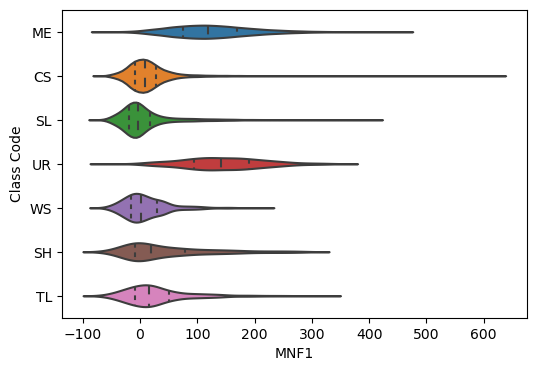

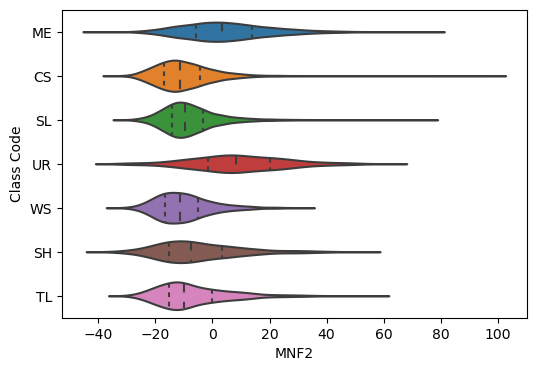

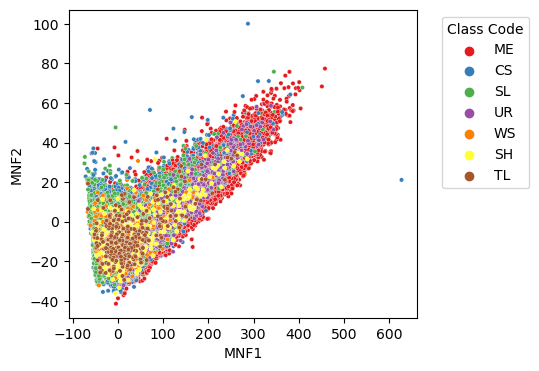

['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']
[[ 14.95337918  -9.80524206]
 [124.87557651   4.92124453]
 [ 45.47368468  -5.01590767]
 [  8.03510633  -7.89044744]
 [ 29.45440109  -6.76093764]
 [144.44153124   9.18238566]
 [ 10.07189758  -9.91733039]]
[[  8.14124107 -11.25185013]
 [119.10548782   3.45857131]
 [ 19.2093668   -7.56221914]
 [ -4.12617111  -9.50196362]
 [ 15.6369915   -9.83998394]
 [141.37571716   8.21003437]
 [  2.31631148 -11.22171783]]


In [30]:
##################################
# Load the spectral library data #
##################################

projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials'

# Read in the potential endmembers spatial data frame (MNF1,MNF2)
ref_sp_path = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials\
/data/spatial/mod/dc_data/training/dc_data_reference_sampled_mnf.gpkg'
ref_sp = gpd.read_file(ref_sp_path)
ref_sp = ref_sp.to_crs(proj)  # ensure the correct projection
ref_sp = ref_sp[['class_code', 'uid', 'mnf1', 'mnf2', 'geometry']]
print(ref_sp.columns.values)

# Get the summary of each endmember class spectral response)
summary_stats = ref_sp.groupby('class_code')[['mnf1','mnf2']].describe()
print(summary_stats)

# Create horizontal violin plot for MNF1
plt.figure(figsize=(6, 4))
sns.violinplot(x='mnf1', y='class_code', data=ref_sp, inner='quartile')
plt.xlabel('MNF1')
plt.ylabel('Class Code')
plt.show()

# Create horizontal violin plot for MNF2
plt.figure(figsize=(6, 4))
sns.violinplot(x='mnf2', y='class_code', data=ref_sp, inner='quartile')
plt.xlabel('MNF2')
plt.ylabel('Class Code')
plt.show()

# Create a scatter plot with MNF1 and MNF2, colored by class code
plt.figure(figsize=(4.5, 4))
sns.scatterplot(x='mnf1', y='mnf2', hue='class_code', data=ref_sp, palette='Set1', s=10)
plt.xlabel('MNF1')
plt.ylabel('MNF2')
plt.legend(title='Class Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create an array of the class means
print(ref_sp['class_code'].unique())
# Create a mean and median np array
means_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].mean()
means_array = means_by_class.values  # Convert the means to a NumPy array
print(means_array)
# Median
med_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].median()
med_array = med_by_class.values
print(med_array)

In [36]:
# Bring in the full spectral library
ref_sp_f_path = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials\
/data/spatial/mod/dc_data/training/dc_data_reference_sampled.gpkg'
ref_sp_f = gpd.read_file(ref_sp_f_path)
ref_sp_f = ref_sp_f.to_crs(proj)  # ensure the correct projection
print(ref_sp_f.columns.values)
# Check on the summary from the 'ndre' band
print(ref_sp_f['ndre'].describe())

['index' 'class_code' 'areaUTMsqft' 'uid' 'description' 'coastal_blue'
 'blue' 'green_i' 'green' 'yellow' 'red' 'rededge' 'nir' 'ndre' 'vgnir'
 'vrnir' 'ndbibg' 'ndbirg' 'geometry']
count    63910.000000
mean         0.284583
std          0.142039
min         -0.034430
25%          0.155710
50%          0.287453
75%          0.398387
max          0.716093
Name: ndre, dtype: float64


In [40]:
# Attemp to create a threshold for vegetation
veg = pd.read_csv(os.path.join(projdir,'data/tabular/mod/dc_data/training/dc_data_veg_sampled.csv'))
print(veg['ndre'].describe())
# Filter the training samples to remove possible vegetation cover, reclaulate the median array
ref_sp_f = ref_sp_f[ref_sp_f['ndre'] < 0.4]
ref_sp = ref_sp[ref_sp['uid'].isin(ref_sp_f['uid'])]
# Get the summary of each endmember class spectral response)
summary_stats = ref_sp.groupby('class_code')[['mnf1','mnf2']].describe()
print(summary_stats)

# Create an array of the class means
print(ref_sp['class_code'].unique())
# Create a mean and median np array
means_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].mean()
means_array = means_by_class.values  # Convert the means to a NumPy array
print("Mean Array:")
print(means_array)
# Median
med_by_class = ref_sp.groupby('class_code')[['mnf1', 'mnf2']].median()
med_array = med_by_class.values
print("Median Array:")
print(med_array)

count    43.000000
mean      0.605845
std       0.075303
min       0.425480
25%       0.555723
50%       0.624561
75%       0.667683
max       0.698196
Name: ndre, dtype: float64
               mnf1                                                           \
              count        mean        std        min        25%         50%   
class_code                                                                     
CS          15431.0   32.376111  40.964429 -24.299030   8.679424   21.204987   
ME          26181.0  127.601089  67.841316 -15.686580  77.345177  120.782471   
SH            371.0   75.601176  73.762390 -19.340263  16.318737   53.713551   
SL           4445.0   43.481461  54.695144 -17.967400   7.213145   22.432020   
TL            403.0   52.253538  56.797370 -14.979664  14.435089   31.183643   
UR            912.0  145.291285  68.461459 -10.621248  95.322617  142.257896   
WS            443.0   34.805862  36.980729 -15.555125   9.236181   25.548447   

                    

/opt/miniconda3/envs/rooftop-materials/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Shape: (2, 7555, 6046); 
NoData Value: 3.4028234663852886e+38; 
Bands: <xarray.DataArray 'band' (band: 2)>
array([1, 2])
Coordinates:
  * band         (band) int64 1 2
    spatial_ref  int64 0; 
Band Names: ('mnf1', 'mnf2'); 
Data Type: float32


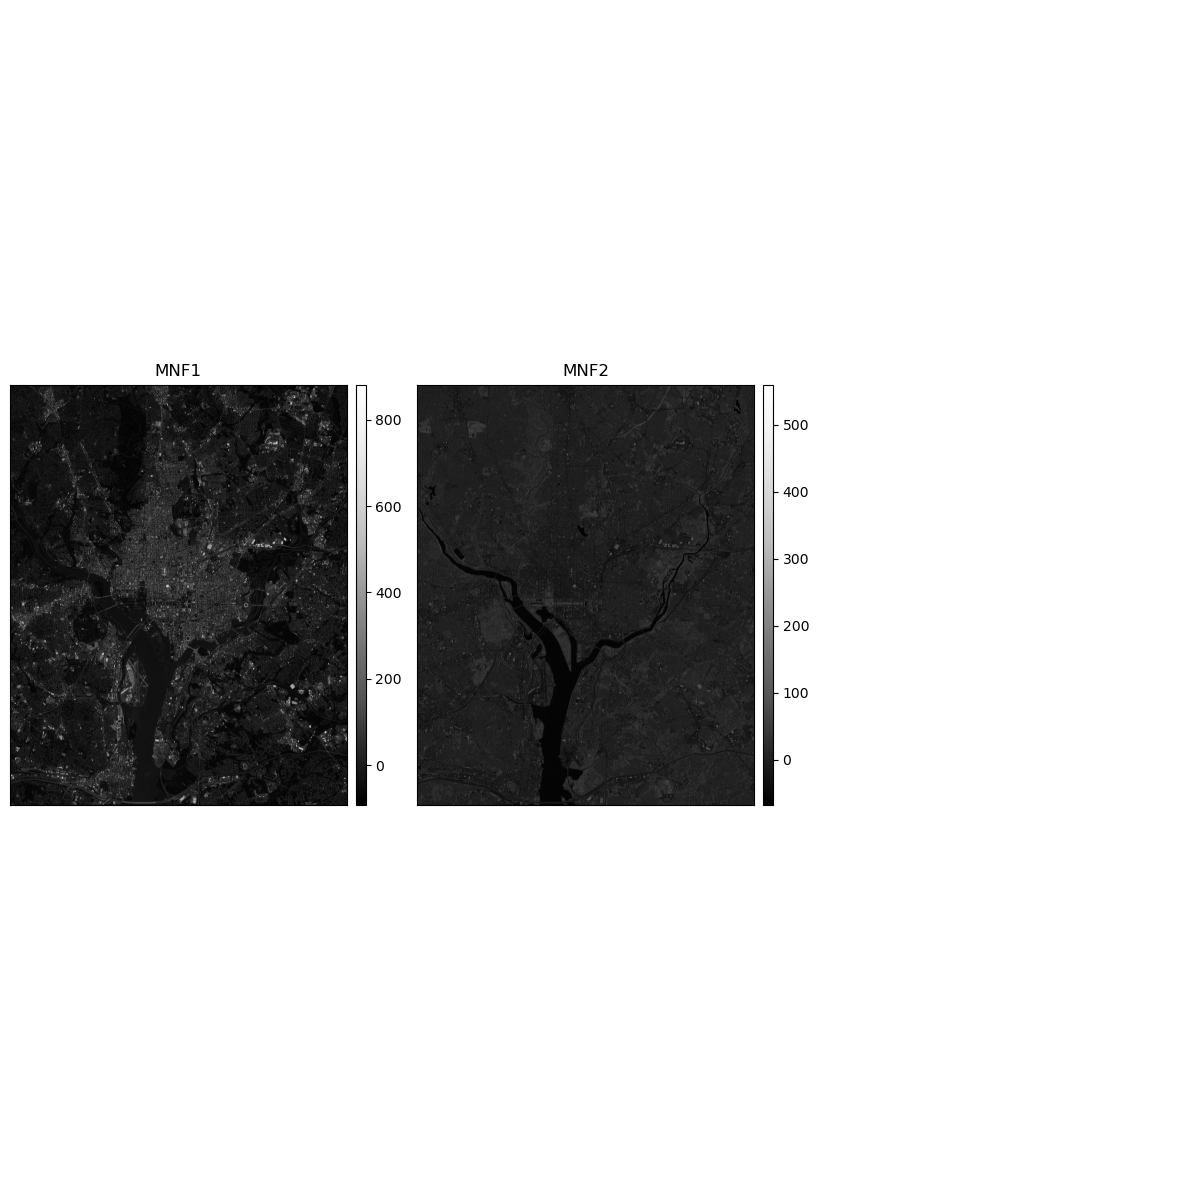

In [41]:
# Bring in the image file and get the projection information
image_path = os.path.join(projdir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene13b_mnf_.tif')
stack = rxr.open_rasterio(image_path,masked=True,cache=False).rio.reproject(proj)
print(
    f"Shape: {stack.shape}; \n"
    f"NoData Value: {stack.rio.nodata}; \n"
    f"Bands: {stack.band}; \n"
    f"Band Names: {stack.long_name}; \n"
    f"Data Type: {stack[0].dtype}")
# Plot one image as an example (green band)
ep.plot_bands(
    stack,
    scale=False,
    title=["MNF1","MNF2"]
)
stack_mnf = stack

In [43]:
# Grab projection information
# Get the WKT and GeoTransform
gdal.UseExceptions()  # Enable errors
try:
    ds = gdal.Open(image_path)
    gt = ds.GetGeoTransform()
    wkt = ds.GetProjection()
except RuntimeError:  # <- Check first what exception is being thrown
    pass
del ds
print(f"GeoTransform: {gt}; \nWKT: {wkt}")

GeoTransform: (316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0); 
WKT: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [11]:
def PPI_(M, q, numSkewers, mask=None, ini_skewers=None, num_iterations=10):
    """
    Performs the pixel purity index algorithm for endmember finding.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data ((m x n) x p).

        q: `int`
            Number of endmembers to find.

        numSkewers: `int`
            Number of "skewer" vectors to project data onto.

        ini_skewers: `numpy array [default None]`
            You can generate skewers from another source.

    Returns: `numpy array`
        Recovered endmembers (N x p).
    """
    p, m, n = M.shape

    # Reshape to have bands as columns
    M = M.reshape(p, -1).T

    # Apply the mask if provided
    if mask is not None:
        # Flatten the mask and apply
        mask_reshaped = mask.values.flatten()
        M_masked = M[mask_reshaped != 0]
    else:
        M_masked = M

    # Remove mean from data
    u = np.mean(M_masked, axis=0)
    Mm = M_masked - np.kron(np.ones((M_masked.shape[0], 1)), u)
    
    all_endmembers = []
    for _ in range(num_iterations):
        # # Randomly sample a subset of the data
        # num_samples = min(50000, Mm.shape[0])  # Limit to 5000 samples or the number of rows if less
        # sampled_data_idx = random.sample(range(Mm.shape[0]), num_samples)
        # Mm_sampled = Mm[sampled_data_idx, :]

        # Generate skewers
        if ini_skewers is None:
            np.random.seed(0)  # Seed for reproducibility
            ini_skewers = np.random.rand(p, numSkewers)

        # Randomly select a subset of skewers for this iteration
        selected_skewers = ini_skewers[:, np.random.choice(numSkewers, numSkewers, replace=False)]

        votes = np.zeros((Mm.shape[0], 1))

        for kk in range(numSkewers):
            tmp = np.abs(np.dot(Mm, selected_skewers[:, kk]))
            idx = np.argmax(tmp)
            votes[idx] = votes[idx] + 1

        max_idx = np.argsort(votes, axis=None)
        end_member_idx = max_idx[-q:][::-1]
        U = Mm[end_member_idx, :]
        print(U.T)
        
        all_endmembers.append(U.T)
    
    all_endmembers_ = np.concatenate(all_endmembers)
    print(all_endmembers_.shape)

    return all_endmembers, np.mean(all_endmembers, axis=0), end_member_idx



In [201]:
# def PPI_(M, q, numSkewers, mask=None, ini_skewers=None, iters=10):
#     """
#     Performs the pixel purity index algorithm for endmember finding.

#     Parameters:
#         M: `numpy array`
#             2d matrix of HSI data ((m x n) x p).

#         q: `int`
#             Number of endmembers to find.

#         numSkewers: `int`
#             Number of "skewer" vectors to project data onto.

#         ini_skewers: `numpy array [default None]`
#             You can generate skewers from another source.

#     Returns: `numpy array`
#         Recovered endmembers (N x p).
#     """
    
#     print(f'Extracting endmembers over {str(iters)} iterations ...')
    
#     p, m, n = M.shape
    
#     all_endmembers = []  # List to store endmembers for each iteration
#     for i in range(iters):
        
#         # Reshape to have bands as columns
#         M = M.reshape(p, -1).T

#         # Apply the mask if provided
#         if mask is not None:
#             # Flatten the mask and apply
#             mask_reshaped = mask.values.flatten()
#             M_masked = M[mask_reshaped != 0]
#         else:
#             M_masked = M
        
#         # Remove mean from data
#         u = np.mean(M_masked, axis=0)
#         Mm = M_masked - np.kron(np.ones((M_masked.shape[0], 1)), u)

#         # Generate skewers
#         if ini_skewers is None:
#             skewers = np.random.rand(p, numSkewers)
#         else:
#             skewers = ini_skewers

#         votes = np.zeros((Mm.shape[0], 1))

#         for kk in range(numSkewers):
#             tmp = np.abs(np.dot(Mm, skewers[:, kk]))
#             idx = np.argmax(tmp)
#             votes[idx] = votes[idx] + 1

#         max_idx = np.argsort(votes, axis=None)
#         end_member_idx = max_idx[-q:][::-1]
#         U = Mm[end_member_idx, :]
        
#         all_endmembers.append(U.T)
    
#     all_endmembers_ = np.concatenate(all_endmembers)
#     print(all_endmembers_.shape)
    
#     # Return the mean of endmembers obtained in all iterations
#     return all_endmembers, np.mean(all_endmembers, axis=0)

Roofing Material Types: ['ME' 'CS' 'SL' 'UR' 'WS' 'SH' 'TL']
Starting endmember extraction for ME
Mask: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/data/spatial/mod/dc_data/training/masks/ME_mask.tif; 
Shape: (7555, 6046); 
NoData: 0; 
Type: <class 'xarray.core.dataarray.DataArray'>; 
DType: uint8


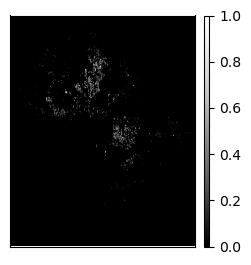

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


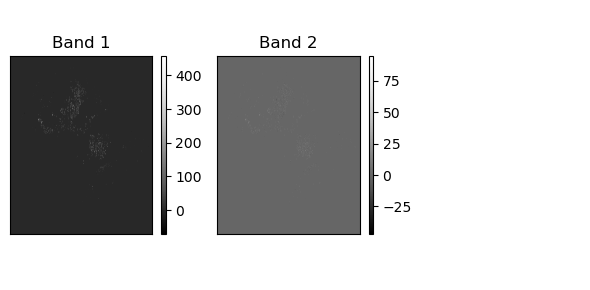

(20, 1)
Pixel Purity Index Results for ME: ([array([[-116.12287045],
       [ -11.76206994]]), array([[-75.51515198],
       [-11.73430562]]), array([[-49.54473114],
       [  1.06328654]]), array([[-33.3295517 ],
       [-10.91066813]]), array([[139.1615448 ],
       [ 23.38797736]]), array([[-7.91044617],
       [-4.20810926]]), array([[50.62896729],
       [ 7.54439235]]), array([[-19.87739563],
       [ -1.85418427]]), array([[4.18836212],
       [1.99963546]]), array([[-67.30483246],
       [-18.14438748]])], array([[-17.56261053],
       [ -2.4618433 ]]), array([36189]))
(20, 1)
Pixel Purity Index Results for ME: ([array([[-105.96116066],
       [ -29.8763907 ]]), array([[-112.80697584],
       [ -10.45090461]]), array([[-61.25959778],
       [-22.14838815]]), array([[22.08856201],
       [13.44896293]]), array([[-62.26596069],
       [ -8.17453265]]), array([[-49.00671387],
       [-10.7583425 ]]), array([[-95.47929382],
       [  1.12658334]]), array([[ 8.05751801],
       [-0.

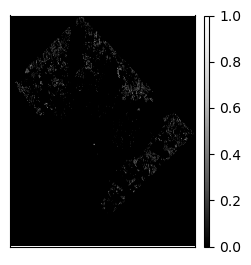

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


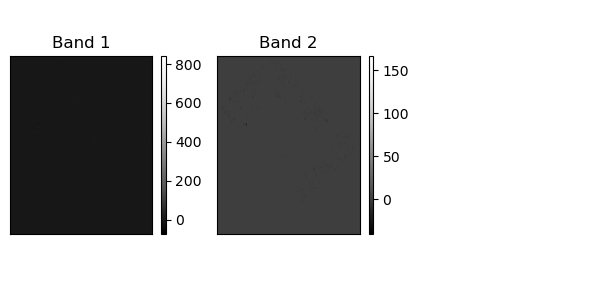

(20, 1)
Pixel Purity Index Results for CS: ([array([[33.58906794],
       [ 0.8694253 ]]), array([[124.77323008],
       [ 15.25695848]]), array([[-4.23207021],
       [ 7.11611515]]), array([[-10.64067984],
       [  3.69889545]]), array([[-13.16215515],
       [-12.10095882]]), array([[-0.5926919 ],
       [-6.79165459]]), array([[10.96799898],
       [ 9.74200547]]), array([[-42.91306067],
       [-15.95180416]]), array([[-7.22437072],
       [ 5.96628022]]), array([[-20.22371626],
       [  8.40730843]])], array([[7.03415523],
       [1.62125709]]), array([33652]))
(20, 1)
Pixel Purity Index Results for CS: ([array([[ 2.34355974],
       [-5.56643963]]), array([[-4.25744939],
       [-5.01300812]]), array([[8.232059  ],
       [7.60360858]]), array([[-32.51011229],
       [  2.54646778]]), array([[-24.49363279],
       [  0.26475382]]), array([[-20.05167437],
       [ -9.76630878]]), array([[-33.81826925],
       [  5.50302172]]), array([[-37.1106658 ],
       [  2.32151127]]), arr

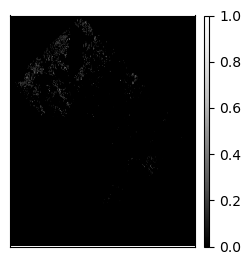

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


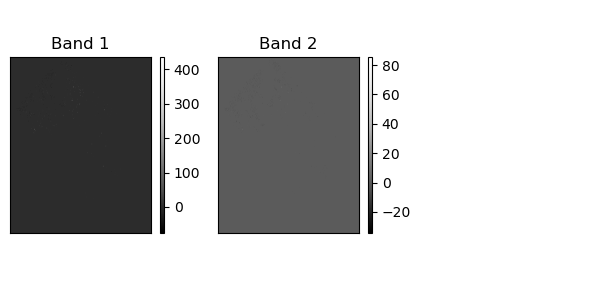

(20, 1)
Pixel Purity Index Results for SL: ([array([[-26.95263648],
       [  5.63152099]]), array([[15.87708592],
       [-5.45701361]]), array([[-4.52095008],
       [-6.21602678]]), array([[140.47732186],
       [ 28.21033812]]), array([[-36.03380942],
       [-10.27896547]]), array([[46.9160502 ],
       [29.86260748]]), array([[-41.09971213],
       [ 17.29677534]]), array([[-4.32647014],
       [-9.28023481]]), array([[ 3.88940716],
       [-3.39212561]]), array([[-47.26508307],
       [  4.64736784]])], array([[4.69612038],
       [5.10242435]]), array([3675]))
(20, 1)
Pixel Purity Index Results for SL: ([array([[-30.30857253],
       [ -0.8604188 ]]), array([[-13.07160926],
       [ -2.04517698]]), array([[13.0528214 ],
       [ 4.78922391]]), array([[3.48262382],
       [4.04736614]]), array([[ 24.10826707],
       [-12.5127511 ]]), array([[-25.89012313],
       [  2.19354343]]), array([[ 6.21009135],
       [-3.49401426]]), array([[-39.41759849],
       [ 14.25583982]]), arra

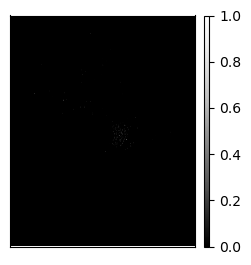

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


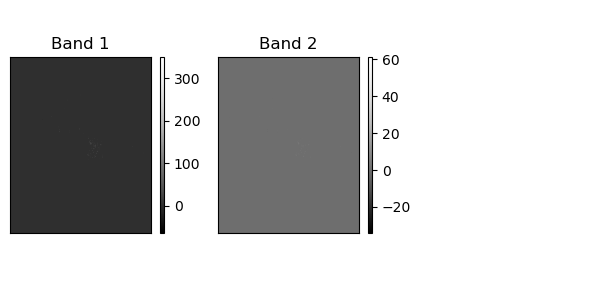

(20, 1)
Pixel Purity Index Results for UR: ([array([[-21.38659668],
       [-10.10939479]]), array([[60.81175232],
       [ 7.83873749]]), array([[-33.30322266],
       [-14.30449963]]), array([[-83.82740021],
       [-32.13126755]]), array([[85.68086243],
       [16.02072525]]), array([[-58.82594299],
       [-13.72330141]]), array([[61.76014709],
       [16.91413116]]), array([[-36.41278076],
       [ -3.6637094 ]]), array([[25.97767639],
       [ 6.76957512]]), array([[ 0.35476685],
       [16.0866642 ]])], array([[ 0.08292618],
       [-1.03023396]]), array([3756]))
(20, 1)
Pixel Purity Index Results for UR: ([array([[-63.32686996],
       [-24.8015976 ]]), array([[-31.1709671 ],
       [ -9.88681912]]), array([[-10.27028656],
       [-16.43536758]]), array([[-11.14642334],
       [  2.13614273]]), array([[46.35121155],
       [13.37503815]]), array([[-56.72512817],
       [ -4.73386216]]), array([[-36.81315613],
       [ -8.67052293]]), array([[23.8135376 ],
       [-2.31387424]])

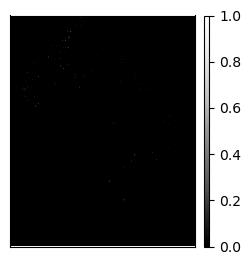

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


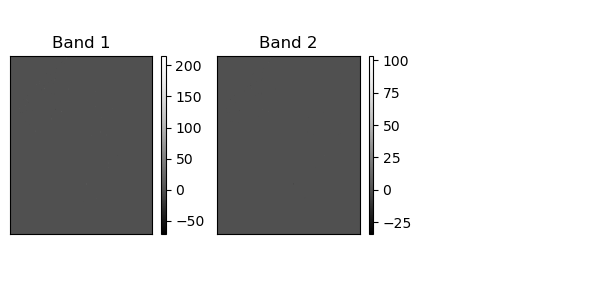

(20, 1)
Pixel Purity Index Results for WS: ([array([[23.28218782],
       [-5.04227829]]), array([[61.45232522],
       [15.84886074]]), array([[27.61813676],
       [ 2.91571474]]), array([[-29.65576231],
       [ -2.76956558]]), array([[-22.58530867],
       [  5.10437179]]), array([[ 19.19500482],
       [-16.36056232]]), array([[-15.59086859],
       [-13.60146427]]), array([[  3.1775707 ],
       [-16.10579014]]), array([[ -6.7469269 ],
       [-12.32157612]]), array([[-47.12480032],
       [  3.74589038]])], array([[ 1.30215585],
       [-3.85863991]]), array([7130]))
(20, 1)
Pixel Purity Index Results for WS: ([array([[ -6.7469269 ],
       [-12.32157612]]), array([[-8.30732405],
       [-9.8864584 ]]), array([[19.8064779 ],
       [-5.86944008]]), array([[-23.34672034],
       [ -3.29824543]]), array([[17.19742334],
       [-4.17376804]]), array([[-34.63715613],
       [ -0.28539562]]), array([[ 4.00316083],
       [-6.81633568]]), array([[-15.16682112],
       [ -3.58719635]])

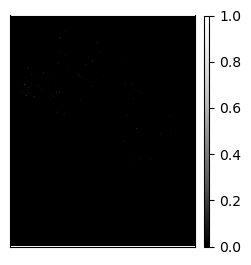

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


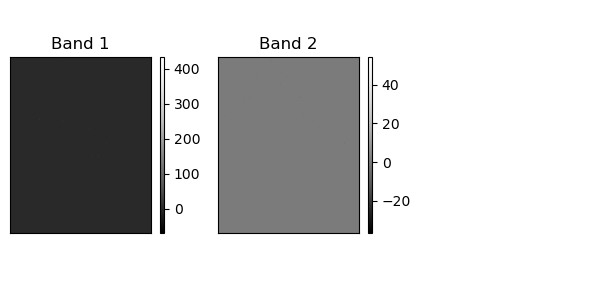

(20, 1)
Pixel Purity Index Results for SH: ([array([[133.77869987],
       [ 21.84751749]]), array([[108.7302227 ],
       [  8.01481795]]), array([[47.15441704],
       [ 8.09269881]]), array([[-17.21824551],
       [-14.01258612]]), array([[-40.92656136],
       [ -2.41999054]]), array([[20.20801353],
       [-9.26848745]]), array([[-30.23624134],
       [ -5.50642252]]), array([[14.90147591],
       [ 1.08207273]]), array([[-56.90007973],
       [ 17.99162245]]), array([[132.89921379],
       [ 21.83144236]])], array([[31.23909149],
       [ 4.76526852]]), array([240]))
(20, 1)
Pixel Purity Index Results for SH: ([array([[-73.38590813],
       [  0.09115219]]), array([[186.8855114 ],
       [ 42.10148668]]), array([[3.50439262],
       [0.67810488]]), array([[-11.35510921],
       [-17.54725218]]), array([[-53.26484299],
       [-11.68600988]]), array([[-34.89319801],
       [-25.57117224]]), array([[-67.21737862],
       [-11.60029364]]), array([[-55.72546196],
       [  6.52387607

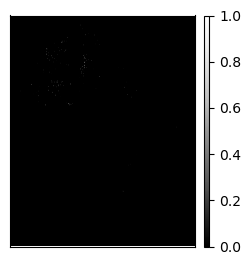

<xarray.DataArray (y: 7555, x: 6046)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0
(2, 7555, 6046)


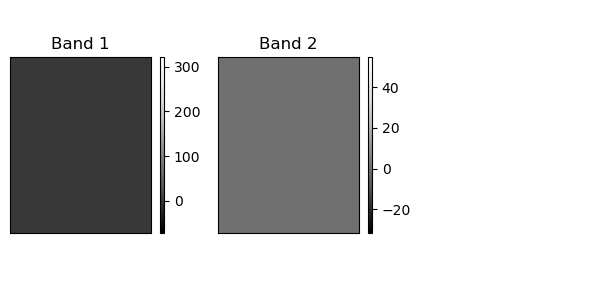

(20, 1)
Pixel Purity Index Results for TL: ([array([[-11.31952095],
       [  0.86883688]]), array([[-4.60359859],
       [ 6.47877586]]), array([[-40.27985382],
       [ -3.14385128]]), array([[-13.67412829],
       [-11.20771694]]), array([[-36.95854568],
       [ -9.96102047]]), array([[ -2.3935585 ],
       [-10.22586727]]), array([[-9.29836941],
       [-3.87748909]]), array([[ 2.55260468],
       [-1.75385475]]), array([[ -1.37174225],
       [-15.76582241]]), array([[-20.06199336],
       [-16.32981968]])], array([[-13.74087062],
       [ -6.49178292]]), array([5920]))
(20, 1)
Pixel Purity Index Results for TL: ([array([[-16.04429531],
       [ -1.53678513]]), array([[-55.74932671],
       [-19.60883617]]), array([[-5.15644836],
       [-3.09262085]]), array([[-13.19045973],
       [ -9.61229229]]), array([[-2.09824276],
       [16.29248524]]), array([[-7.59837055],
       [ 0.14259291]]), array([[-61.01319695],
       [  3.38668942]]), array([[70.01628304],
       [ 7.20685828]

In [10]:
import glob
# Load the roof type masks
masks_dir = 'data/spatial/mod/dc_data/training/masks/'
masks = glob.glob(os.path.join(projdir,masks_dir,'*.tif'))

# Grab the class codes
groups = ref_sp['class_code'].unique()
print(f"Roofing Material Types: {groups}")

# Loop through the material types,
# open the mask layer, perform the PPI for each type

iters = 10

ems_p_mat = []
ems_mean_p_mat = []
for i in range(len(groups)):
    cl = groups[i]
    print(f"Starting endmember extraction for {cl}")
    
    # Get a list of roof type masks
    mask_path = list(filter(lambda x: cl in x, masks))
    # Open the corresponding mask
    mask = rxr.open_rasterio(mask_path[0], cache=False).squeeze().astype('uint8')
    print(f"Mask: {mask_path[0]}; \n"
          f"Shape: {mask.shape}; \n"
          f"NoData: {mask.rio.nodata}; \n"
          f"Type: {type(mask)}; \n"
          f"DType: {mask.dtype}")
    ep.plot_bands(mask, figsize=(3,3))
    
    # Make it a boolean mask
    mask_bool = mask == 1
    mask_bool = mask_bool.astype(bool)
    print(mask_bool)

    # Mask the input MNF array stack to footprints
    stack_mnf_ = stack_mnf * mask_bool
    stack_mnf_ = np.asarray(stack_mnf_)
    print(stack_mnf_.shape)
    ep.plot_bands(stack_mnf_, figsize=(6,3))

    # Set up the EEA
    for i in range(iters):
        ems  = PPI_(stack_mnf_, q=1, numSkewers=5000, mask=mask_bool)
        print(f"Pixel Purity Index Results for {cl}: {ems}")
        ems_p_mat.append(ems)
    

In [186]:
for i in range(len(ems_p_mat)):
    print(groups[i])
    em = ems_p_mat[i].T
    print(f"Endmember array: \n{np.asarray(em)} \nShape: {em.shape} \nType: {type(em)}")

ME
Endmember array: 
[ 3.49661041e+02  9.16895502e+01 -1.18582129e-01  3.34359707e+02
  3.70653766e+02 -5.07330298e-01  3.52369637e+02 -2.36594424e-01
  3.84295075e+02 -2.47340292e-01 -2.27519780e-01  3.59814772e+02
 -2.48487875e-01  3.27852019e+02 -2.95876443e-01  3.45869950e+02
  3.46263898e+02 -2.88887888e-01 -3.07257593e-01  3.93237278e+02] 
Shape: (20,) 
Type: <class 'numpy.ndarray'>
CS
Endmember array: 
[ 7.71273825e+02  1.02654584e+02  2.40100561e+02  2.83906073e-03
  3.14609064e+02  2.22543720e-02  3.76277660e+02  5.84121421e-03
  3.22402903e+02  5.28145116e-03 -3.77381127e-03  3.33693172e+02
  5.06742997e-03  2.78776922e+02  2.59901355e+02  5.28335571e-03
  2.30919676e+02  1.53830377e-02  5.53289289e-03  2.95943080e+02] 
Shape: (20,) 
Type: <class 'numpy.ndarray'>
SL
Endmember array: 
[ 4.37001049e+02  8.15807681e+01  1.24858236e-02  1.56634474e+02
  1.50696319e-02  2.13174133e+02  7.97498226e-03  2.10118907e+02
  3.03020467e+02 -2.54930439e-03  2.62389009e+02  1.10124610e-02


In [130]:
############################################
# Fully Constrained Least Squares Unmixing #
# Linear Spectral Mixture Analysis (LSMA)  #
# Single endmember per group               #
############################################

import time
import traceback

num_processes = mp.cpu_count() - 1
print(f"Splitting across {num_processes} chunks for work ...")

# Check the data shapes
print(f"Image array (MNF) shape: {stack_mnf_.shape}; Endmember array shape: {rand_ems_arr.shape}")

# Split the MNF-transformed stack into chunks to be processed
chunks = np.array_split(stack_mnf_[:2,:,:], num_processes, axis=2)

# Perform FCLS unmixing in parallel
start_time = time.time()
if __name__ == '__main__':
    
    # Function to parallelize FCLS unmixing
    def parallel_fcls_unmixing(chunk, endmembers):
        try:
            am = amap.FCLS()
            return am.map(chunk.T, endmembers, normalize=False)
        except Exception as e:
            traceback.print_exc()
            raise e
    
    with mp.Pool(processes=num_processes) as pool:
        try:
            unmix_results = pool.map(partial(parallel_fcls_unmixing, endmembers=rand_ems_arr), chunks)
            pool.close()
        except Exception as e:
            traceback.print_exc()
            raise e
        finally:
            pool.terminate()
            pool.join() 
            
print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.") 


Splitting across 31 chunks for work ...
Image array (MNF) shape: (4, 7555, 6046); Endmember array shape: (7, 3)
Time elapsed: 8375.3 seconds.


In [131]:
# Retrieve the results
print(type(unmix_results))
print(len(unmix_results))
# Combine the FCLS results from all chunks back into a single array
ams_combined_parallel = np.concatenate(unmix_results)
print(f"Final combined array shape: {ams_combined_parallel.shape}")

<class 'list'>
31
Final combined array shape: (6046, 7555, 7)


In [132]:
print(gt, wkt)

(316167.0, 3.0, 0.0, 4318398.0, 0.0, -3.0) PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [133]:
###############################
# Dump raster, export GeoTIFF #
###############################

from osgeo import gdal, gdal_array

def dump_raster(rast, rast_path, driver='GTiff', gdt=None, nodata=None):
    """
    Creates a raster file from a given gdal.Dataset instance. Arguments:
        rast        A gdal.Dataset; does NOT accept NumPy array
        rast_path   The path of the output raster file
        driver      The name of the GDAL driver to use (determines file type)
        gdt         The GDAL data type to use, e.g., see gdal.GDT_Float32
        nodata      The NoData value; defaults to -9999.
    """
    if gdt is None:
        gdt = rast.GetRasterBand(1).DataType
    driver = gdal.GetDriverByName(driver)
    sink = driver.Create(
        rast_path, rast.RasterXSize, rast.RasterYSize, rast.RasterCount, int(gdt))
    assert sink is not None, 'Cannot create dataset; there may be a problem with the output path you specified'
    sink.SetGeoTransform(rast.GetGeoTransform())
    sink.SetProjection(rast.GetProjection())
    
    for b in range(1, rast.RasterCount + 1):
        dat = rast.GetRasterBand(b).ReadAsArray()
        sink.GetRasterBand(b).WriteArray(dat)
        sink.GetRasterBand(b).SetStatistics(*map(np.float64,
            [dat.min(), dat.max(), dat.mean(), dat.std()]))

        if nodata is None:
            nodata = rast.GetRasterBand(b).GetNoDataValue()

            if nodata is None:
                nodata = -9999

        sink.GetRasterBand(b).SetNoDataValue(np.float64(nodata))

    sink.FlushCache()
    
def array_to_raster(a, gt, wkt, xoff=None, yoff=None, dtype=None):
    """
    Creates a raster from a given array, with optional x- and y-offsets
    if the array was clipped. Arguments:
        a       A NumPy array
        gt      A GDAL GeoTransform tuple
        wkt     Well-Known Text projection
        xoff    The offset in the x-direction; should be provided when clipped
        yoff    The offset in the y-direction; should be provided when clipped
        dtype   The data type to coerce on the array
    """
    if dtype is not None:
        a = a.astype(dtype)
    try:
        rast = gdal_array.OpenNumPyArray(a)
    except AttributeError:
        # For backwards compatibility with older version of GDAL
        rast = gdal.Open(gdalnumeric.GetArrayFilename(a))
    except:
        rast = gdal_array.OpenArray(a)
    rast.SetGeoTransform(gt)
    rast.SetProjection(wkt)
    if xoff is not None and yoff is not None:
        # Bit of a hack; essentially, re-create the raster but with the
        #   correct X and Y offsets (don't know how to do this without the
        #   use of CopyDatasetInfo())
        return array_to_raster_clone(a, rast, xoff, yoff)
    return rast

In [75]:
# Bring in the image file and get the projection information
image_path = '/home/jovyan/20220605_PSScene13B_Mosaic_DC.tif'
stack = rxr.open_rasterio(image_path,masked=True)
stack = stack.rio.reproject(proj)

In [137]:
# Export the abundance ndarray as a multiband raster
import xarray as xr

print(f"Original shape: {stack_mnf.shape}; \nAbundance maps shape: {ams_combined_parallel.shape}")
print(f"Length of 'y' attribute: {stack_mnf.y}; \nLength of shape[1]: {ams_combined_parallel.shape[1]}")

# Transpose the new array before exporting
in_arr = ams_combined_parallel.transpose(2, 1, 0)
print(in_arr.shape)

# Assign the correct coordinates for the transposed 'y' dimension
band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform
out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_manual.tif"
out_arr.rio.to_raster(output_path, compress='zstd', zstd_level=1,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")

Original shape: (4, 7555, 6046); 
Abundance maps shape: (6046, 7555, 7)
Length of 'y' attribute: <xarray.DataArray 'y' (y: 7555)>
array([4318294.5, 4318291.5, 4318288.5, ..., 4295638.5, 4295635.5, 4295632.5])
Coordinates:
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0; 
Length of shape[1]: 7555
(7, 7555, 6046)
Success !! ...


Class 0: CS
Class 1: ME
Class 2: SL
Class 3: UR
Class 4: TL
Class 5: WS
Class 6: SH


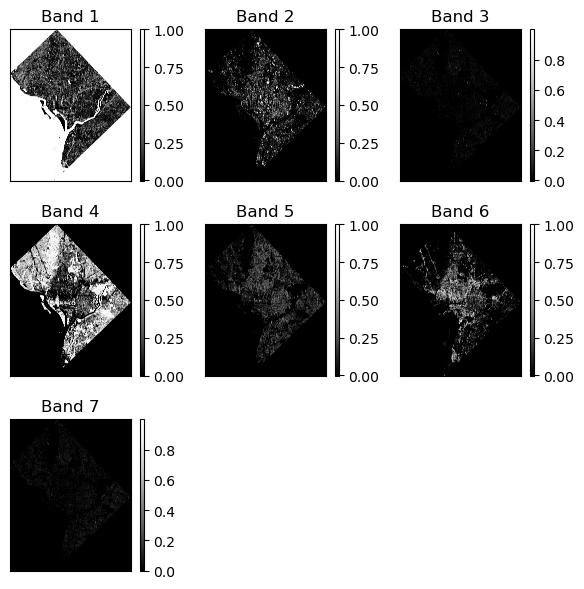

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [136]:
# Test the output array by plotting the first abundance map
for i in range(len(groups)):
    print(f"Class {i}: {groups[i]}")
ep.plot_bands(
    ams_combined_parallel.T,
    scale=False,
    figsize=(6,6))